In [1]:
import pandas as pd
import numpy as np
import os
import json
import statistics
import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from dateutil import parser
import datetime
import matplotlib.pyplot as plt
from dateutil.tz import tzutc
import math

In [2]:
d = "./result_long"

dirs_to_analyze = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o)) and "\\experiment" in os.path.join(d, o)]


In [3]:
rowsList = []
numjobs = []
batches = []

for curdir in dirs_to_analyze:
    row = {}    
    try:
        time_summary = json.load(open(curdir + "/summary.json"))
        service_times = []
        process_times = []
        wait_times = []
        
        start_time = parser.parse(time_summary["start"])
        end_time = parser.parse(time_summary["shutdown"])

        time_offset = datetime.timedelta(minutes=30)
        batch_start_time = start_time + time_offset

        batch_start_seconds = (batch_start_time-datetime.datetime(1970,1,1).replace(tzinfo=tzutc())).total_seconds()
        end_seconds = (end_time.replace(tzinfo=None)-datetime.datetime(1970,1,1)).total_seconds()

        num_batches = 4

        batch_delta = (end_seconds - batch_start_seconds) / float(num_batches)


        batch_num = 0
        batch_jobs = []

        for batch_start in np.arange(batch_start_seconds, end_seconds, batch_delta):
            batch_num = batch_num + 1
#             print("Batch ", batch_num)
#             print(batch_start, " - ", batch_start + batch_delta)
            new_batch_jobs = []

            i = -1
            for job in time_summary['jobs']:
                i = i + 1
                if (float(job['end']) >= batch_start) & (float(job['end']) < batch_start + batch_delta):
                    new_batch_jobs.append(i)

#             print("Num jobs", len(new_batch_jobs))
            numjobs.append(len(new_batch_jobs))
            batch_jobs.append(new_batch_jobs)
        
        batches.append(batch_jobs)
        
        row['Num generated'] = time_summary['jobCount']

        for job in time_summary['jobs']:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)

        row['Service Time mean'] = statistics.mean(service_times)
        row['Service Time std'] = statistics.stdev(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Process Time std'] = statistics.stdev(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Waiting Time std'] = statistics.stdev(wait_times)
    except Exception as e:
        print("Error parsing time summary for folder " + curdir)
        print(e)
        
    try:
        config = json.load(open(curdir + "/config.json"))
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])

    except Exception as e:
        print("Error parsing config for folder " + curdir)
        print(e)
        
    try:
        accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
        row['Num finished'] = accuracy["top1"].count()
        row['Top 1 mean'] = accuracy["top1"].mean()
        row['Top 1 std'] = accuracy["top1"].std()
        row['Top 5 mean'] = accuracy["top5"].mean()
        row['Top 5 std'] = accuracy["top5"].std()
        row['loss mean'] = accuracy["loss"].mean()
        row['loss std'] = accuracy["loss"].std()
        row['lossnum'] = accuracy["lossnum"].mean()
    except Exception as e:
        print("Error parsing accuracy for folder " + curdir)
        print(e)
        
    
    rowsList.append(row) 
    
analysis_old = pd.DataFrame(rowsList)
# analysis_old

In [6]:
# mu = analysis["Top 1 mean"].mean()
# sigma = analysis["Top 1 mean"].std()
mu = 0.9
sigma = 0.05
def z_score(x, mu, sig):
    return (x-mu)/sig

In [9]:
## Creating batches
rowsList = []
numjobs = []

new_df = pd.DataFrame(columns=analysis_old.columns)
i = -1
for curdir in dirs_to_analyze:
#     print(curdir)
    i = i + 1
    time_summary = json.load(open(curdir + "/summary.json"))
    config = json.load(open(curdir + "/config.json"))
    accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
    accuracy["Experiment"] = [int(x.split(".")[0]) for x in accuracy.index]

    experiment_batches = batches[i]
    batch_num = 0
    for curbat in experiment_batches:
        batch_num = batch_num + 1
        if len(curbat) == 0:
            continue
        row = {}
        
        service_times = []
        process_times = []
        wait_times = []
        batch_summary = time_summary['jobs'][min(curbat):max(curbat)+1]
        for job in batch_summary:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)
        row['Batch Number'] = batch_num
        row['Experiment Number'] = i
        row['Service Time mean'] = statistics.mean(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])
        
        
        row['Experiment Name'] = str(row['Batch Size']) + " - " + str(row['Max Epochs']) + " - " + str(row['Learning Rate'])
        
        batch_accuracy = accuracy[accuracy["Experiment"].isin(curbat)]
        row['Num finished'] = batch_accuracy["top1"].count()
        row['Top 1 mean'] = batch_accuracy["top1"].mean()
        row['Top 1 std'] = batch_accuracy["top1"].std()
        row['Top 5 mean'] = batch_accuracy["top5"].mean()
        row['Top 5 std'] = batch_accuracy["top5"].std()
        row['loss mean'] = batch_accuracy["loss"].mean()
        row['loss std'] = batch_accuracy["loss"].std()
        row['lossnum'] = batch_accuracy["lossnum"].mean()
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['EZscore1'] = math.e**row['Zscore1'] /  row['Service Time mean']
        row['EZscore5'] = math.e**row['Zscore5'] / row['Service Time mean']
        
        rowsList.append(row) 
    
analysis_batch = pd.DataFrame(rowsList)
analysis_batch

,Batch Number,Experiment Number,Service Time mean,Process Time mean,Waiting Time mean,Executor Memory,Batch Size,Max Epochs,Learning Rate,Nodes,...,Top 1 std,Top 5 mean,Top 5 std,loss mean,loss std,lossnum,Zscore1,Zscore5,EZscore1,EZscore5
0,1,0,523.205719,523.205645,0.000074,1,128,10,0.005,1,...,0.008061,0.995400,0.000283,0.320982,0.010210,157.0,0.278000,1.908000,0.002524,0.012881
1,2,0,521.276814,521.276731,0.000083,1,128,10,0.005,1,...,0.002553,0.996533,0.000473,0.306239,0.004603,157.0,0.356000,1.930667,0.002739,0.013225
2,3,0,789.010816,529.829070,259.181745,1,128,10,0.005,1,...,0.005302,0.995680,0.000517,0.314583,0.016267,157.0,0.327600,1.913600,0.001759,0.008590
3,4,0,1449.641481,545.099980,904.541502,1,128,10,0.005,1,...,0.003976,0.996167,0.000712,0.305998,0.015216,157.0,0.388333,1.923333,0.001017,0.004721
4,1,1,1817.286394,919.909957,897.376438,1,128,20,0.005,1,...,0.002304,0.997920,0.000356,0.221667,0.008146,157.0,0.736400,1.958400,0.001149,0.003900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,4,25,12157.408238,1561.927681,10595.480557,1,64,20,0.020,1,...,0.000757,0.999867,0.000058,0.069822,0.001971,313.0,1.586666,1.997333,0.000402,0.000606
100,1,26,923.621292,484.908643,438.712648,1,64,5,0.020,1,...,0.002140,0.999500,0.000115,0.114563,0.005581,313.0,1.326857,1.990000,0.004081,0.007920
101,2,26,431.771805,431.771597,0.000208,1,64,5,0.020,1,...,0.002258,0.999650,0.000129,0.117241,0.006077,313.0,1.301000,1.993000,0.008507,0.016994
102,3,26,460.051439,460.051366,0.000073,1,64,5,0.020,1,...,NaN,0.999600,NaN,0.125618,NaN,313.0,1.248000,1.992000,0.007572,0.015933


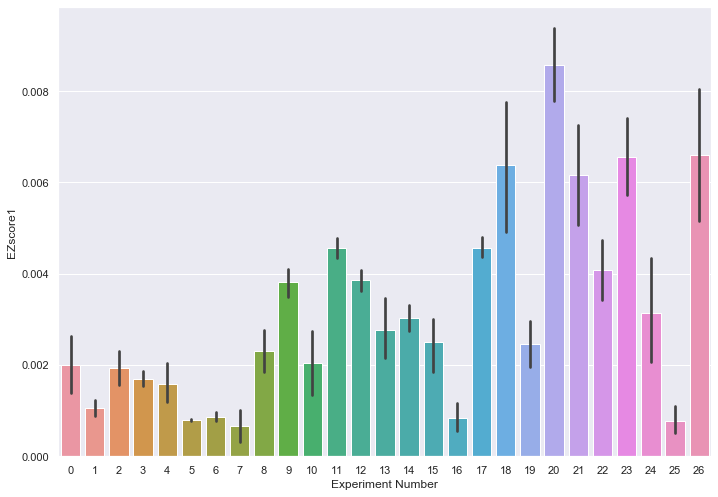

In [10]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x="Experiment Number", y="EZscore1", data=analysis_batch, ci=90)

(0.8, 1.0)

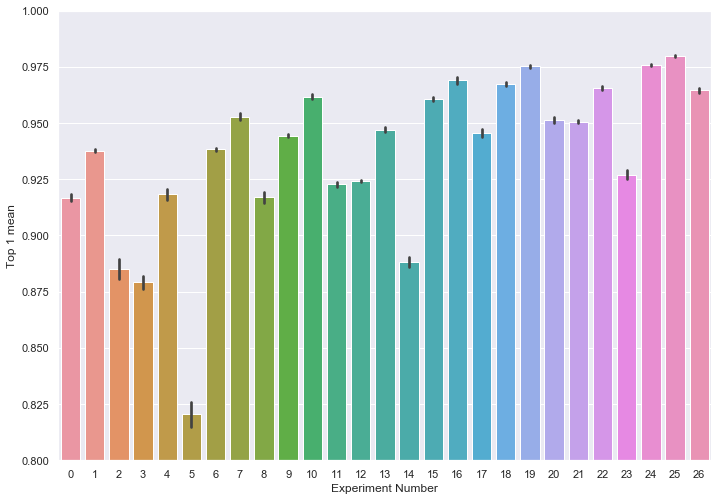

In [11]:
bp = sns.barplot(x="Experiment Number", y="Top 1 mean", data=analysis_batch, ci=90)
axes = bp.axes
axes.set_ylim(0.8,1.0)

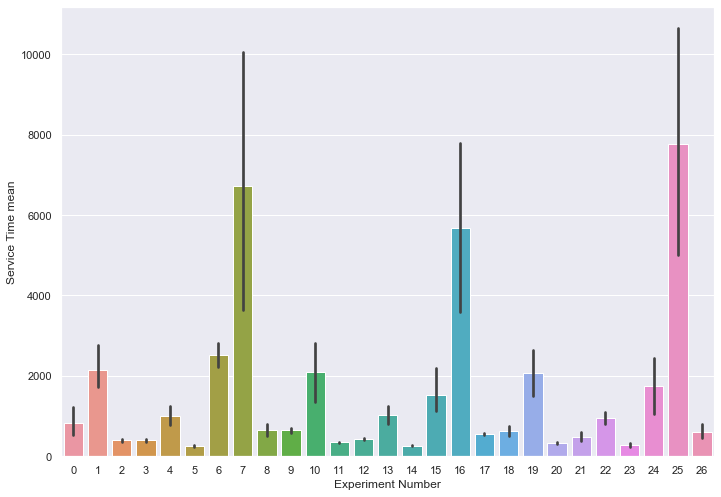

In [12]:
sns.barplot(x="Experiment Number", y="Service Time mean", data=analysis_batch, ci=90)


In [13]:
print("Chosen experiments")

best_number = analysis_batch.groupby("Experiment Number")["EZscore1"].mean().sort_values(ascending=False).index[0]
fast_number = analysis_batch.groupby("Experiment Number")["Service Time mean"].mean().sort_values().index[0]
accuracy_number = analysis_batch.groupby("Experiment Number")["Top 1 mean"].mean().sort_values(ascending=False).index[0]
final_experiments = [best_number, fast_number, accuracy_number]
df_final  = analysis_batch[analysis_batch["Experiment Number"].isin(final_experiments)][["Experiment Number", "Batch Size", "Max Epochs", "Learning Rate", "Lambda"]].drop_duplicates()
df_final

Chosen experiments


,Experiment Number,Batch Size,Max Epochs,Learning Rate,Lambda
20,5,256,5,0.005,0.001
78,20,128,5,0.020,0.001
96,25,64,20,0.020,0.001


In [17]:
## For bash commands:

cols = ["learningRate", "batchSize", "maxEpoch", "numberOfNodes", "lambda"]
nodes = [2, 4]
output_df = df_final.append([df_final]*(len(nodes)-1), ignore_index=True)
output_df = output_df.drop(columns=["Experiment Number"])
output_df["Nodes"] = np.sort(nodes*3)
output_df = output_df.rename(columns={'Batch Size':cols[1], 'Max Epochs':cols[2], 'Learning Rate':cols[0], 'Nodes':cols[3], "Lambda": cols[4]})
output_df

,batchSize,maxEpoch,learningRate,lambda,numberOfNodes
0,256,5,0.005,0.001,2
1,128,5,0.020,0.001,2
2,64,20,0.020,0.001,2
3,256,5,0.005,0.001,4
4,128,5,0.020,0.001,4
5,64,20,0.020,0.001,4


In [18]:
print(output_df.to_dict())

{'batchSize': {0: 256, 1: 128, 2: 64, 3: 256, 4: 128, 5: 64}, 'maxEpoch': {0: 5, 1: 5, 2: 20, 3: 5, 4: 5, 5: 20}, 'learningRate': {0: 0.005, 1: 0.02, 2: 0.02, 3: 0.005, 4: 0.02, 5: 0.02}, 'lambda': {0: 0.001, 1: 0.001, 2: 0.001, 3: 0.001, 4: 0.001, 5: 0.001}, 'numberOfNodes': {0: 2, 1: 2, 2: 2, 3: 4, 4: 4, 5: 4}}


In [16]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Top 1 mean", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Top 1 mean": "Acc", "Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('Acc ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

LinAlgError: SVD did not converge

In [ ]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["EZscore1", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('EZscore1 ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

In [ ]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Process Time mean", "Batch Size", "Max Epochs", "Learning Rate"]]
analysis2 = analysis2.rename(columns={"Process Time mean" : "PT","Batch Size": "BS", "Max Epochs": "ME", "Learning Rate": "LR"})

# This will also automatically include the main effects for each factor
model = ols('PT ~ C(BS)*C(ME)*C(LR)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

In [ ]:
# Process time results:
print("Max avg process time: ", analysis["Process Time mean"].max())
print("Min avg process time: ", analysis["Process Time mean"].min())
print("Mean avg process time: ", analysis["Process Time mean"].mean())

print("Min mu: ", "%.7f" % (1/analysis["Process Time mean"].max()))
print("Max mu: ", "%.7f" % (1/analysis["Process Time mean"].min()))
print("Mean mu: ", "%.7f" % (1/analysis["Process Time mean"].mean()))


In [ ]:
important_cols=[x for x in analysis.columns if "Top 1" in x]
important_cols.extend([x for x in analysis.columns if "Time" in x])


In [ ]:
display(rp.summary_cont(analysis[[x for x in important_cols if "Process Time mean" in x]].groupby(analysis["Batch Size"])))

In [ ]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

In [ ]:
analysis.sort_values(by=['Top 1 mean'], ascending=False)

In [ ]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

In [ ]:
## Service time / accuracy^(something) (adapted IES)
alpha = 2
analysis["Acc/Service"] = analysis['Service Time mean']/(analysis['Top 1 mean']**alpha)
display(analysis.sort_values(by=['Acc/Service']).head())
display(analysis.sort_values(by=['Acc/Service']).tail())

In [ ]:
## LISAS score, lower is better

analysis["LISAS"] = analysis['Service Time mean'] + analysis["Service Time std"] / analysis["Top 1 std"] * (1-analysis["Top 1 mean"])
display(analysis.sort_values(by=['LISAS']).head())
display(analysis.sort_values(by=['LISAS']).tail())


In [ ]:
## Adapted RCS
c = analysis["Num finished"] * analysis["Top 1 mean"]
sumRT = analysis["Num finished"] * analysis["Service Time mean"]
analysis["RCS"] = c / sumRT
display(analysis.sort_values(by=['RCS'], ascending=False).head())
display(analysis.sort_values(by=['RCS'], ascending=False).tail())